### Overview

This kernel implements a CNN with a squeeze-and-excitation mechanism. The rationale is using sigmoid gates to reduce the effects of noise  from the original inputs. The gate parameters are learned to differentiate useful filters and less useful ones, and hopefully less useful ones are more suppressed with lower sigmoid coefficients.

The original paper for the squeeze-and-excitation mechanism:

https://arxiv.org/abs/1709.01507

Some codes were borrowed from these kernels (Great thanks!):

https://www.kaggle.com/gpreda/lanl-earthquake-eda-and-prediction

https://www.kaggle.com/friedchips/how-to-reduce-the-training-data-to-400mb

https://www.kaggle.com/tandonarpit6/lanl-earthquake-prediction-fast-ai

https://www.kaggle.com/rtatman/download-a-csv-file-from-a-kernel



In [1]:
## Read in training data (from https://www.kaggle.com/gpreda/lanl-earthquake-eda-and-prediction)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

%time train = pd.read_csv("../input/train.csv", dtype={"acoustic_data": np.int16, "time_to_failure": np.float32})

CPU times: user 2min 6s, sys: 9.17 s, total: 2min 15s
Wall time: 2min 16s


### Sample Data Generation

To evaluate the squeeze-and-excitation mechanism with a subset of data, in total 2,550 samples with 15,0000 consecutive points were generated from 17 pre-failure periods. The model was trained with 5-fold cross validation and test data was predicted with the average outputs from the five models of each cv.

In [2]:
# Split the whole training segments into five cross-folds.
# There are 17 pre-failure periods in the training data, so samples for five cross folds were randomly selected 
# from pre-failure periods with index 0 - 3, 4 - 6, 7 - 9, 10 - 12, and 13 - 16.

sample_num = 150
input_len = 150000
np.random.seed(7898)

# From https://www.kaggle.com/friedchips/how-to-reduce-the-training-data-to-400mb
ttf = train["time_to_failure"].values
index_start = np.nonzero(np.diff(ttf) > 0)[0] + 1
index_start = np.insert(index_start, 0, 0) # insert 1st period start manually
chunk_length = np.diff(np.append(index_start, train.shape[0]))

X_series = []
y_series = []
# Split 17 pre-failure periods into five cross-folds, where the last four folds starts at index of 4, 7, 10 and 13th pre-failure period
cv_assign = [4, 7, 10, 13]
X, y = None, None
for i in range(len(index_start)):
    if i in cv_assign:
        X_series.append(X)
        y_series.append(y)
        X, y = None, None
    index_set = np.random.randint(low=index_start[i], high=index_start[i] + chunk_length[i] - input_len, size=sample_num)
    ac_data = np.zeros((sample_num,input_len, 1), dtype=np.int16)
    ac_label = np.zeros((sample_num,), dtype=np.float32)
    for j in range(sample_num):
        ac_data[j, :, 0] = train["acoustic_data"].values[index_set[j]:index_set[j] + input_len]
        ac_label[j] = train["time_to_failure"].values[index_set[j] + input_len]
    if X is None: X, y = ac_data, ac_label
    else:
        X, y = np.concatenate((X, ac_data), axis=0), np.concatenate((y, ac_label), axis=0)
X_series.append(X)
y_series.append(y)
del train # Just to save space

# From https://www.kaggle.com/tandonarpit6/lanl-earthquake-prediction-fast-ai
submission = pd.read_csv("../input/sample_submission.csv", index_col="seg_id")
X_test = np.zeros((2624, 150000, 1), dtype=np.int32)
i = 0
for seg_id in tqdm_notebook(submission.index):
    seg = pd.read_csv("../input/test/{}.csv".format(seg_id))
    X_test[i, :, :] = seg.values
    i += 1

### Model Architecture

The input into the model is a segment with length 15,0000. The model first reduces all signals by 100 fold, and followed by two convolutional layers. Squeeze-and-excitation mechanism and a max-pooling layer are filled in between two conv layers. The final output is calculated with an intermediate dense layer from the second conv layer.

In [3]:
#Generate CNN model with a squeeze-and-excitation mechanism
from keras.models import Sequential, Model
from keras.layers import Input, Conv1D, MaxPooling1D, Dense, Flatten, Multiply, Dropout, Lambda, GlobalAveragePooling1D
from keras.optimizers import Adam

def squeeze_block(x, filter_num):
    squeeze = GlobalAveragePooling1D()(x)
    squeeze = Dense(int(filter_num / 2), activation="relu", kernel_initializer="he_normal")(squeeze)
    squeeze = Dense(filter_num, activation="sigmoid", kernel_initializer="he_normal", name="squeeze_coef")(squeeze)
    c = Multiply()([x, squeeze])
    return c

def model_gen(InputDim):
    print("Building model ...")
    inputs = Input((InputDim, 1))
    c = Lambda(lambda x: x / 100.0)(inputs)
    c = Conv1D(filters=16, kernel_size=(10,), strides=1, padding="valid", 
               kernel_initializer="he_normal", activation="relu", name="conv_before_squeeze")(c)
    c = squeeze_block(c, 16)
    c = MaxPooling1D(pool_size=10, strides=10, padding="valid")(c)
    c = Conv1D(filters=16, kernel_size=(10,), strides=5, padding="valid", 
               kernel_initializer="he_normal", activation='relu', name="conv_after_squeeze")(c)
    f = Flatten()(c)
    d = Dense(64, activation="relu", kernel_initializer="he_normal")(f)
    d = Dropout(rate=0.5)(d)
    outputs = Dense(1, activation="elu", kernel_initializer="he_normal")(d)
    model = Model(inputs=[inputs], outputs=[outputs])
    optim = Adam(lr=0.005)
    model.compile(loss="mean_absolute_error", optimizer=optim)
    return model
model = model_gen(150000)
model.summary()

Using TensorFlow backend.


Building model ...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150000, 1)    0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 150000, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv_before_squeeze (Conv1D)    (None, 149991, 16)   176         lambda_1[0][0]                   
__________________________________________________________________________________________________
gl

### Model Training

A decaying learning rate scheduler was applied.

For each cross-fold, the model was trained for 30 epochs, and the model from the last epoch was used to predict the test data.

In [4]:
# Model training with 5-cv

import numpy as np
from keras.callbacks import LearningRateScheduler

batch_size = 50
epochs_number = 30

def step_decay(epoch):
    initial_lrate = 0.005
    drop = 0.8
    epochs_drop = 5.0
    lrate = initial_lrate * np.power(drop, np.floor((1 + epoch) / epochs_drop))
    return lrate
lrate = LearningRateScheduler(step_decay)

model_loss = np.zeros((5,), dtype=np.float32)
y_pred_series = []
y_test = np.zeros((2624, 1), dtype=np.float32)

for i in range(len(X_series)):
    model = model_gen(input_len)
    X_fit, y_fit = None, None
    for j in range(len(X_series)):
        if j != i:
            if X_fit is None: X_fit, y_fit = X_series[j], y_series[j]
            else:
                X_fit, y_fit = np.concatenate((X_fit, X_series[j]), axis=0), np.concatenate((y_fit, y_series[j]), axis=0)
    X_val, y_val = X_series[i], y_series[i]
    model.fit(X_fit, y_fit, batch_size=batch_size, epochs=epochs_number, 
              validation_data=(X_val, y_val), shuffle=True, callbacks=[lrate])
    model_loss[i] = model.evaluate(X_val, y_val)
    y_pred_series.append(model.predict(X_val))
    y_test += model.predict(X_test)
model.save_weights(filepath="model_param.hdf5")
    
model_loss_mean = np.mean(model_loss)
model_loss_std = np.std(model_loss)
print("CV Score for the model is {:.3f} +/- {:.3f}".format(model_loss_mean, model_loss_std))
submission.time_to_failure = y_test / 5
submission.to_csv("submission.csv", index=True)

Building model ...
Instructions for updating:
Use tf.cast instead.
Train on 1950 samples, validate on 600 samples
Epoch 1/30
1950/1950 [==============================] - 7s 4ms/step - loss: 4.7129 - val_loss: 3.3340
Epoch 2/30
1950/1950 [==============================] - 4s 2ms/step - loss: 2.8747 - val_loss: 2.7317
Epoch 3/30
1950/1950 [==============================] - 4s 2ms/step - loss: 2.5878 - val_loss: 2.5728
Epoch 4/30
1950/1950 [==============================] - 4s 2ms/step - loss: 2.4555 - val_loss: 2.7359
Epoch 5/30
1950/1950 [==============================] - 4s 2ms/step - loss: 2.3873 - val_loss: 2.4761
Epoch 6/30
1950/1950 [==============================] - 4s 2ms/step - loss: 2.2871 - val_loss: 2.5560
Epoch 7/30
1950/1950 [==============================] - 4s 2ms/step - loss: 2.1311 - val_loss: 2.6136
Epoch 8/30
1950/1950 [==============================] - 4s 2ms/step - loss: 2.1586 - val_loss: 2.5187
Epoch 9/30
1950/1950 [==============================] - 4s 2ms/step - 

2100/2100 [==============================] - 4s 2ms/step - loss: 1.8494 - val_loss: 2.4452
Epoch 16/30
2100/2100 [==============================] - 4s 2ms/step - loss: 1.9362 - val_loss: 2.4337
Epoch 17/30
2100/2100 [==============================] - 4s 2ms/step - loss: 1.8715 - val_loss: 2.4827
Epoch 18/30
2100/2100 [==============================] - 4s 2ms/step - loss: 1.7948 - val_loss: 2.5901
Epoch 19/30
2100/2100 [==============================] - 4s 2ms/step - loss: 1.8414 - val_loss: 2.4758
Epoch 20/30
2100/2100 [==============================] - 4s 2ms/step - loss: 1.8163 - val_loss: 2.4622
Epoch 21/30
2100/2100 [==============================] - 4s 2ms/step - loss: 1.7341 - val_loss: 2.5161
Epoch 22/30
2100/2100 [==============================] - 4s 2ms/step - loss: 1.7481 - val_loss: 2.4596
Epoch 23/30
2100/2100 [==============================] - 4s 2ms/step - loss: 1.7456 - val_loss: 2.5027
Epoch 24/30
2100/2100 [==============================] - 4s 2ms/step - loss: 1.7058 -

### Model Evaluation

Model from each cross-fold was used to predict the validation fold to have a comparison with ground truth. The model tends to overestimate small failure time and underestimate large failure time.

CV Score for the model is 2.379 +/- 0.268


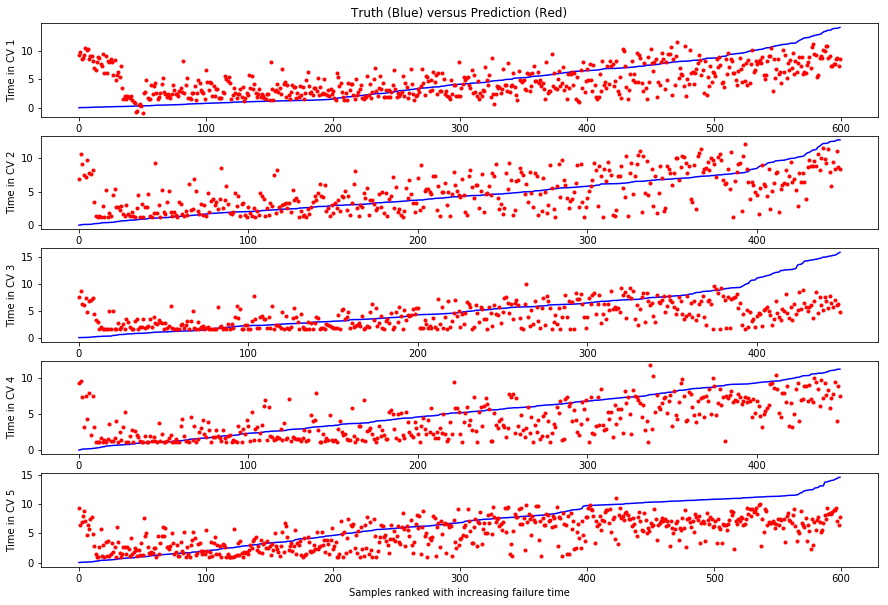

In [8]:
print("CV Score for the model is {:.3f} +/- {:.3f}".format(model_loss_mean, model_loss_std))
fig, ax = plt.subplots(5, 1, figsize=(15, 10))
for i in range(len(y_pred_series)):
    index = np.argsort(y_series[i])
    ax[i].plot(np.arange(y_series[i].shape[0]), y_series[i][index], "b-")
    ax[i].plot(np.arange(y_pred_series[i].shape[0]), y_pred_series[i][index], "r.")
    ax[i].set_ylabel("Time in CV {}".format(i + 1))
    if i == 0:
        ax[i].set_title("Truth (Blue) versus Prediction (Red)")
    ax[-1].set_xlabel("Samples ranked with increasing failure time")

To evaluate the efficiency of the squeeze-and-excitation mechanism, one sample with the largest failure time from the last cross-fold was picked to generate the outputs of convolutional layers. Note that each conv layer has 16 filters, so the outputs of first conv layer were shown in left four columns (start from second row), and ones for second conv layer were in right four columns.

It seems all squeeze coefficients for 16 filters in first conv layer were around 0.50. While it could mean the squeeze-and-excitation didn't do the job as expected, interestingly, the CNN model without it performs consistently WORSE than with it (didn't show in current kernel).

Text(0, 0.5, 'Second Conv Outputs After Squeezing')

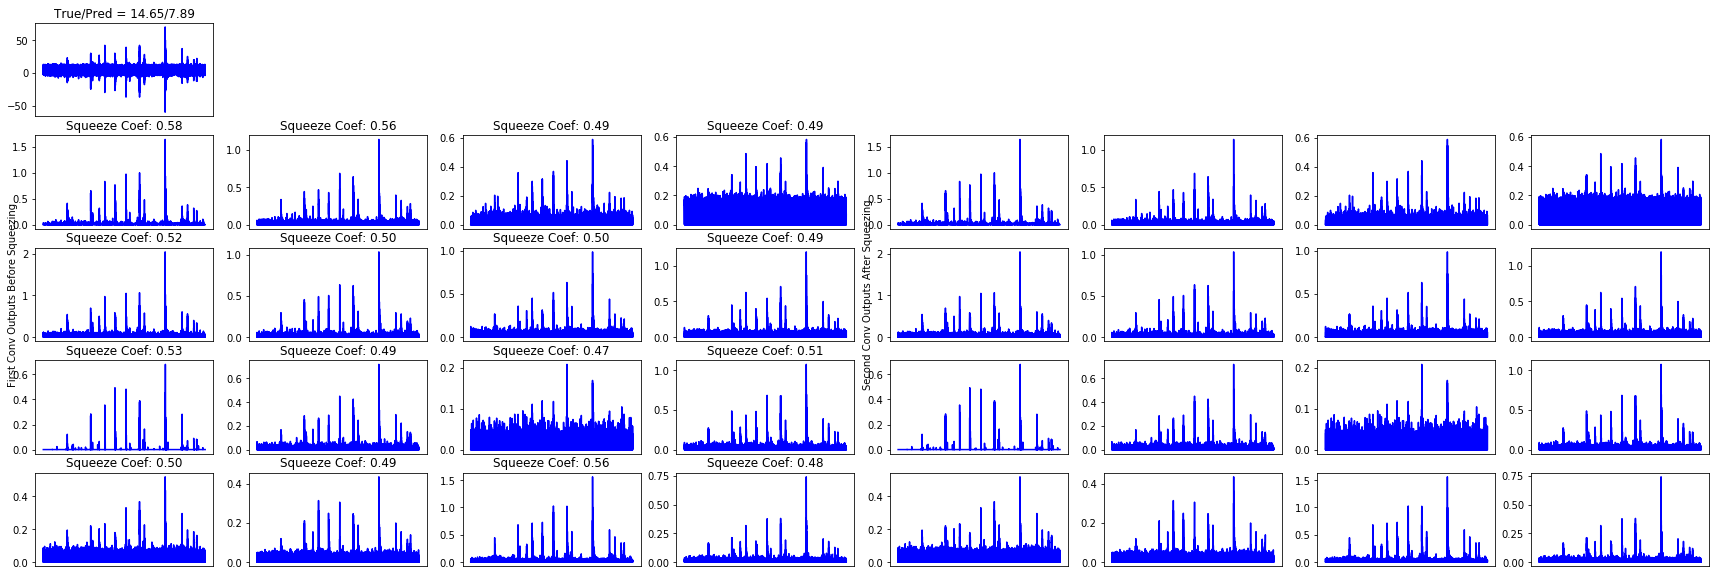

In [20]:
from keras import backend as K

I = y_val.argsort()[-1] # Pick some sample with the largest failure time
x = X_val[I, :, :]
y = y_val[I]
x = np.expand_dims(x, axis=0)
y_pred = model.predict(x)[0][0]

get_pre_squeeze_conv_layer_output = K.function([model.layers[0].input],
                                  [model.get_layer("conv_before_squeeze").output])
get_post_squeeze_conv_layer_output = K.function([model.layers[0].input],
                                      [model.get_layer("conv_before_squeeze").output])
get_squeeze_coefficients = K.function([model.layers[0].input],
                                      [model.get_layer("squeeze_coef").output])

conv_output = np.array(get_pre_squeeze_conv_layer_output([x])[0])
conv2_output = np.array(get_post_squeeze_conv_layer_output([x])[0])
squeeze_coefs = np.array(get_squeeze_coefficients([x])[0])

r, c = 5, 8
fig, ax = plt.subplots(r, c, figsize=(30, 10))
for i in range(r):
    for j in range(c):
        ax[i][j].set_xticks([])
        if i == 0:
            if j == 0:
                ax[i][j].plot(np.arange(x.shape[1]), x[0, :, 0], "b-")
                ax[i][j].set_title("True/Pred = {:.2f}/{:.2f}".format(y, y_pred))
            else:
                ax[i][j].set_visible(False)
        else:
            if j <= 3:
                k = c // 2 * (i - 1) + j
                ax[i][j].plot(np.arange(conv_output.shape[1]), conv_output[0, :, k], "b-")
                ax[i][j].set_title("Squeeze Coef: {:.2f}".format(squeeze_coefs[0, k]))
            else:
                k = c // 2 * (i - 1) + j - 4
                ax[i][j].plot(np.arange(conv2_output.shape[1]), conv2_output[0, :, k], "b-")
ax[2][0].set_ylabel("First Conv Outputs Before Squeezing")
ax[2][4].set_ylabel("Second Conv Outputs After Squeezing")

One can download the submission.csv from the following codes. The PL score with predictions from this kernel was 1.922. I expect some better scores when one trains the model with the whole set of training data.

In [21]:
# From https://www.kaggle.com/rtatman/download-a-csv-file-from-a-kernel
from IPython.display import HTML
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "submission.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe
create_download_link(submission)